##### Copyright 2020 The TensorFlow Authors.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Playing CartPole with the Actor-Critic method


<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/reinforcement_learning/actor_critic">
    <img src="https://www.tensorflow.org/images/tf_logo_32px.png" />
    View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/reinforcement_learning/actor_critic.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />
    Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/reinforcement_learning/actor_critic.ipynb">
    <img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />
    View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/reinforcement_learning/actor_critic.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

This tutorial demonstrates how to implement the [Actor-Critic](https://papers.nips.cc/paper/1786-actor-critic-algorithms.pdf) method using TensorFlow to train an agent on the [Open AI Gym](https://www.gymlibrary.dev/) [`CartPole-v0`](https://www.gymlibrary.dev/environments/classic_control/cart_pole/) environment.
The reader is assumed to have some familiarity with [policy gradient methods](https://papers.nips.cc/paper/1713-policy-gradient-methods-for-reinforcement-learning-with-function-approximation.pdf) of [(deep) reinforcement learning](https://en.wikipedia.org/wiki/Deep_reinforcement_learning).


**Actor-Critic methods**

Actor-Critic methods are [temporal difference (TD) learning](https://en.wikipedia.org/wiki/Temporal_difference_learning) methods that represent the policy function independent of the value function.

A policy function (or policy) returns a probability distribution over actions that the agent can take based on the given state.
A value function determines the expected return for an agent starting at a given state and acting according to a particular policy forever after.

In the Actor-Critic method, the policy is referred to as the *actor* that proposes a set of possible actions given a state, and the estimated value function is referred to as the *critic*, which evaluates actions taken by the *actor* based on the given policy.

In this tutorial, both the *Actor* and *Critic* will be represented using one neural network with two outputs.


**`CartPole-v0`**

In the [`CartPole-v0` environment](https://www.gymlibrary.dev/environments/classic_control/cart_pole/), a pole is attached to a cart moving along a frictionless track.
The pole starts upright and the goal of the agent is to prevent it from falling over by applying a force of `-1` or `+1` to the cart.
A reward of `+1` is given for every time step the pole remains upright.
An episode ends when: 1) the pole is more than 15 degrees from vertical; or 2) the cart moves more than 2.4 units from the center.

<center>
  <figure>
    <image src="https://tensorflow.org/tutorials/reinforcement_learning/images/cartpole-v0.gif">
    <figcaption>
      Trained actor-critic model in Cartpole-v0 environment
    </figcaption>
  </figure>
</center>


The problem is considered "solved" when the average total reward for the episode reaches 195 over 100 consecutive trials.

## Setup

Import necessary packages and configure global settings.


In [ ]:
!pip install gym[classic_control]
!pip install pyglet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 74.1 MB/s eta 0:00:00
  Attempting uninstall: pygame
    Found existing installation: pygame 2.5.2
    Uninstalling pygame-2.5.2:
      Successfully uninstalled pygame-2.5.2
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 858.3/858.3 kB 6.1 MB/s eta 0:00:00


In [ ]:
%%bash
# Install additional packages for visualization
sudo apt-get install -y python-opengl > /dev/null 2>&1
pip install git+https://github.com/tensorflow/docs > /dev/null 2>&1

In [ ]:
import collections
import gym
import numpy as np
import statistics
import tensorflow as tf
import tqdm

from matplotlib import pyplot as plt
from tensorflow.keras import layers
from typing import Any, List, Sequence, Tuple


# Create the environment
# env = gym.make("CartPole-v1")
env = gym.make("MountainCarContinuous-v0")

# Set seed for experiment reproducibility
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

# Small epsilon value for stabilizing division operations
eps = np.finfo(np.float32).eps.item()

/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


## The model

The *Actor* and *Critic* will be modeled using one neural network that generates the action probabilities and Critic value respectively. This tutorial uses model subclassing to define the model.

During the forward pass, the model will take in the state as the input and will output both action probabilities and critic value $V$, which models the state-dependent [value function](https://spinningup.openai.com/en/latest/spinningup/rl_intro.html#value-functions). The goal is to train a model that chooses actions based on a policy $\pi$ that maximizes expected [return](https://spinningup.openai.com/en/latest/spinningup/rl_intro.html#reward-and-return).

For `CartPole-v0`, there are four values representing the state: cart position, cart-velocity, pole angle and pole velocity respectively. The agent can take two actions to push the cart left (`0`) and right (`1`), respectively.

Refer to [Gym's Cart Pole documentation page](https://www.gymlibrary.dev/environments/classic_control/cart_pole/) and [_Neuronlike adaptive elements that can solve difficult learning control problems_](http://www.derongliu.org/adp/adp-cdrom/Barto1983.pdf) by Barto, Sutton and Anderson (1983) for more information.


In [ ]:
class ActorCritic(tf.keras.Model):
  """Combined actor-critic network."""

  def __init__(
      self,
      num_actions: int,
      num_hidden_units: int):
    """Initialize."""
    super().__init__()

    self.common = layers.Dense(num_hidden_units, activation="relu")
    self.actor = layers.Dense(num_actions)
    self.critic = layers.Dense(1)

  def call(self, inputs: tf.Tensor) -> Tuple[tf.Tensor, tf.Tensor]:
    x = self.common(inputs)
    return self.actor(x), self.critic(x)

In [ ]:
num_actions = env.action_space.n  #Issue here: because the action space is continuous
num_hidden_units = 128

model = ActorCritic(num_actions, num_hidden_units)

TypeError: ignored

## Train the agent

To train the agent, you will follow these steps:

1. Run the agent on the environment to collect training data per episode.
2. Compute expected return at each time step.
3. Compute the loss for the combined Actor-Critic model.
4. Compute gradients and update network parameters.
5. Repeat 1-4 until either success criterion or max episodes has been reached.


### 1. Collect training data

As in supervised learning, in order to train the actor-critic model, you need
to have training data. However, in order to collect such data, the model would
need to be "run" in the environment.

Training data is collected for each episode. Then at each time step, the model's forward pass will be run on the environment's state in order to generate action probabilities and the critic value based on the current policy parameterized by the model's weights.

The next action will be sampled from the action probabilities generated by the model, which would then be applied to the environment, causing the next state and reward to be generated.

This process is implemented in the `run_episode` function, which uses TensorFlow operations so that it can later be compiled into a TensorFlow graph for faster training. Note that `tf.TensorArray`s were used to support Tensor iteration on variable length arrays.

In [ ]:
# Wrap Gym's `env.step` call as an operation in a TensorFlow function.
# This would allow it to be included in a callable TensorFlow graph.

@tf.numpy_function(Tout=[tf.float32, tf.int32, tf.int32])
def env_step(action: np.ndarray) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
  """Returns state, reward and done flag given an action."""

  state, reward, done, info = env.step(action)
  return (state.astype(np.float32),
          np.array(reward, np.int32),
          np.array(done, np.int32))


In [ ]:
def run_episode(
    initial_state: tf.Tensor,
    model: tf.keras.Model,
    max_steps: int) -> Tuple[tf.Tensor, tf.Tensor, tf.Tensor]:
  """Runs a single episode to collect training data."""

  action_probs = tf.TensorArray(dtype=tf.float32, size=0, dynamic_size=True)
  values = tf.TensorArray(dtype=tf.float32, size=0, dynamic_size=True)
  rewards = tf.TensorArray(dtype=tf.int32, size=0, dynamic_size=True)

  initial_state_shape = initial_state.shape
  state = initial_state

  for t in tf.range(max_steps):
    # Convert state into a batched tensor (batch size = 1)
    state = tf.expand_dims(state, 0)

    # Run the model and to get action probabilities and critic value
    action_logits_t, value = model(state)

    # Sample next action from the action probability distribution
    action = tf.random.categorical(action_logits_t, 1)[0, 0]
    action_probs_t = tf.nn.softmax(action_logits_t)

    # Store critic values
    values = values.write(t, tf.squeeze(value))

    # Store log probability of the action chosen
    action_probs = action_probs.write(t, action_probs_t[0, action])

    # Apply action to the environment to get next state and reward
    state, reward, done = env_step(action)
    state.set_shape(initial_state_shape)

    # Store reward
    rewards = rewards.write(t, reward)

    if tf.cast(done, tf.bool):
      break

  action_probs = action_probs.stack()
  values = values.stack()
  rewards = rewards.stack()

  return action_probs, values, rewards

### 2. Compute the expected returns

The sequence of rewards for each timestep $t$, $\{r_{t}\}^{T}_{t=1}$ collected during one episode is converted into a sequence of expected returns $\{G_{t}\}^{T}_{t=1}$ in which the sum of rewards is taken from the current timestep $t$ to $T$ and each reward is multiplied with an exponentially decaying discount factor $\gamma$:

$$G_{t} = \sum^{T}_{t'=t} \gamma^{t'-t}r_{t'}$$

Since $\gamma\in(0,1)$, rewards further out from the current timestep are given less weight.

Intuitively, expected return simply implies that rewards now are better than rewards later. In a mathematical sense, it is to ensure that the sum of the rewards converges.

To stabilize training, the resulting sequence of returns is also standardized (i.e. to have zero mean and unit standard deviation).


In [ ]:
def get_expected_return(
    rewards: tf.Tensor,
    gamma: float,
    standardize: bool = True) -> tf.Tensor:
  """Compute expected returns per timestep."""

  n = tf.shape(rewards)[0]
  returns = tf.TensorArray(dtype=tf.float32, size=n)

  # Start from the end of `rewards` and accumulate reward sums
  # into the `returns` array
  rewards = tf.cast(rewards[::-1], dtype=tf.float32)
  discounted_sum = tf.constant(0.0)
  discounted_sum_shape = discounted_sum.shape
  for i in tf.range(n):
    reward = rewards[i]
    discounted_sum = reward + gamma * discounted_sum
    discounted_sum.set_shape(discounted_sum_shape)
    returns = returns.write(i, discounted_sum)
  returns = returns.stack()[::-1]

  if standardize:
    returns = ((returns - tf.math.reduce_mean(returns)) /
               (tf.math.reduce_std(returns) + eps))

  return returns

### 3. The Actor-Critic loss

Since you're using a hybrid Actor-Critic model, the chosen loss function is a combination of Actor and Critic losses for training, as shown below:

$$L = L_{actor} + L_{critic}$$

#### The Actor loss

The Actor loss is based on [policy gradients with the Critic as a state dependent baseline](https://www.youtube.com/watch?v=EKqxumCuAAY&t=62m23s) and computed with single-sample (per-episode) estimates.

$$L_{actor} = -\sum^{T}_{t=1} \log\pi_{\theta}(a_{t} | s_{t})[G(s_{t}, a_{t})  - V^{\pi}_{\theta}(s_{t})]$$

where:
- $T$: the number of timesteps per episode, which can vary per episode
- $s_{t}$: the state at timestep $t$
- $a_{t}$: chosen action at timestep $t$ given state $s$
- $\pi_{\theta}$: is the policy (Actor) parameterized by $\theta$
- $V^{\pi}_{\theta}$: is the value function (Critic) also parameterized by $\theta$
- $G = G_{t}$: the expected return for a given state, action pair at timestep $t$

A negative term is added to the sum since the idea is to maximize the probabilities of actions yielding higher rewards by minimizing the combined loss.

<br>

##### The Advantage

The $G - V$ term in our $L_{actor}$ formulation is called the [Advantage](https://spinningup.openai.com/en/latest/spinningup/rl_intro.html#advantage-functions), which indicates how much better an action is given a particular state over a random action selected according to the policy $\pi$ for that state.

While it's possible to exclude a baseline, this may result in high variance during training. And the nice thing about choosing the critic $V$ as a baseline is that it trained to be as close as possible to $G$, leading to a lower variance.

In addition, without the Critic, the algorithm would try to increase probabilities for actions taken on a particular state based on expected return, which may not make much of a difference if the relative probabilities between actions remain the same.

For instance, suppose that two actions for a given state would yield the same expected return. Without the Critic, the algorithm would try to raise the probability of these actions based on the objective $J$. With the Critic, it may turn out that there's no Advantage ($G - V = 0$), and thus no benefit gained in increasing the actions' probabilities and the algorithm would set the gradients to zero.

<br>

#### The Critic loss

Training $V$ to be as close possible to $G$ can be set up as a regression problem with the following loss function:

$$L_{critic} = L_{\delta}(G, V^{\pi}_{\theta})$$

where $L_{\delta}$ is the [Huber loss](https://en.wikipedia.org/wiki/Huber_loss), which is less sensitive to outliers in data than squared-error loss.


In [ ]:
huber_loss = tf.keras.losses.Huber(reduction=tf.keras.losses.Reduction.SUM)

def compute_loss(
    action_probs: tf.Tensor,
    values: tf.Tensor,
    returns: tf.Tensor) -> tf.Tensor:
  """Computes the combined Actor-Critic loss."""

  advantage = returns - values

  action_log_probs = tf.math.log(action_probs)
  actor_loss = -tf.math.reduce_sum(action_log_probs * advantage)

  critic_loss = huber_loss(values, returns)

  return actor_loss + critic_loss

### 4. Define the training step to update parameters

All of the steps above are combined into a training step that is run every episode. All steps leading up to the loss function are executed with the `tf.GradientTape` context to enable automatic differentiation.

This tutorial uses the Adam optimizer to apply the gradients to the model parameters.

The sum of the undiscounted rewards, `episode_reward`, is also computed in this step. This value will be used later on to evaluate if the success criterion is met.

The `tf.function` context is applied to the `train_step` function so that it can be compiled into a callable TensorFlow graph, which can lead to 10x speedup in training.


In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)


@tf.function
def train_step(
    initial_state: tf.Tensor,
    model: tf.keras.Model,
    optimizer: tf.keras.optimizers.Optimizer,
    gamma: float,
    max_steps_per_episode: int) -> tf.Tensor:
  """Runs a model training step."""

  with tf.GradientTape() as tape:

    # Run the model for one episode to collect training data
    action_probs, values, rewards = run_episode(
        initial_state, model, max_steps_per_episode)

    # Calculate the expected returns
    returns = get_expected_return(rewards, gamma)

    # Convert training data to appropriate TF tensor shapes
    action_probs, values, returns = [
        tf.expand_dims(x, 1) for x in [action_probs, values, returns]]

    # Calculate the loss values to update our network
    loss = compute_loss(action_probs, values, returns)

  # Compute the gradients from the loss
  grads = tape.gradient(loss, model.trainable_variables)

  # Apply the gradients to the model's parameters
  optimizer.apply_gradients(zip(grads, model.trainable_variables))

  episode_reward = tf.math.reduce_sum(rewards)

  return episode_reward

### 5. Run the training loop

Training is executed by running the training step until either the success criterion or maximum number of episodes is reached.  

A running record of episode rewards is kept in a queue. Once 100 trials are reached, the oldest reward is removed at the left (tail) end of the queue and the newest one is added at the head (right). A running sum of the rewards is also maintained for computational efficiency.

Depending on your runtime, training can finish in less than a minute.

In [ ]:
%%time

min_episodes_criterion = 100
max_episodes = 10000
max_steps_per_episode = 500

# `CartPole-v1` is considered solved if average reward is >= 475 over 500
# consecutive trials
reward_threshold = 475
running_reward = 0

# The discount factor for future rewards
gamma = 0.99

# Keep the last episodes reward
episodes_reward: collections.deque = collections.deque(maxlen=min_episodes_criterion)
print("What is happening",tqdm.trange(max_episodes))
t = tqdm.trange(max_episodes)
for i in t:
    print(env.reset())
    initial_state = env.reset()
    initial_state = tf.constant(initial_state, dtype=tf.float32)
    episode_reward = int(train_step(
        initial_state, model, optimizer, gamma, max_steps_per_episode))

    episodes_reward.append(episode_reward)
    running_reward = statistics.mean(episodes_reward)


    t.set_postfix(
        episode_reward=episode_reward, running_reward=running_reward)

    # Show the average episode reward every 10 episodes
    if i % 10 == 0:
      pass # print(f'Episode {i}: average reward: {avg_reward}')

    if running_reward > reward_threshold and i >= min_episodes_criterion:
        break

print(f'\nSolved at episode {i}: average reward: {running_reward:.2f}!')

  0%|          | 0/10000 [00:00<?, ?it/s]


What is happening   0%|          | 0/10000 [00:00<?, ?it/s]


  0%|          | 0/10000 [00:00<?, ?it/s]

[ 0.01731499 -0.00910528 -0.01614366 -0.0040178 ]


  0%|          | 11/10000 [00:01<16:01, 10.39it/s, episode_reward=17, running_reward=27.8]

[-0.03329241  0.04622146 -0.03369459  0.00779604]
[ 0.02632358 -0.03160829  0.00097184 -0.01436494]
[ 0.01834903 -0.01195293 -0.02018358  0.03606701]
[-0.00362157  0.02626221 -0.01073329  0.03892604]
[ 0.03157183  0.01419619 -0.03239796 -0.04421983]
[ 0.01417085  0.01101423 -0.03193302  0.03276125]
[-0.00095482 -0.04003815 -0.02369518 -0.0245642 ]
[-0.02190696 -0.02818492  0.0352984  -0.01330053]
[-0.04282223  0.04867394 -0.04105465 -0.03332869]
[ 0.0243384   0.04115951 -0.01574316  0.01807069]
[-0.02410092 -0.04147117  0.01450963  0.04968863]
[ 0.03376954 -0.03041764 -0.01993389 -0.03118472]
[0.00825189 0.00743335 0.04255029 0.03906902]
[ 0.02346208 -0.04542428  0.0068163  -0.00602118]
[ 0.03363177  0.01197374 -0.02755721 -0.03861456]
[-0.01402167  0.04323539 -0.00395993  0.01490113]
[ 0.04171494 -0.01684953  0.01084553 -0.04450584]
[-0.03485988 -0.03789507  0.02861892  0.02033543]
[0.01852015 0.04335772 0.04999031 0.02088129]
[ 0.0014141  -0.02758148  0.02486622  0.04800888]
[-0.0212

  0%|          | 31/10000 [00:01<05:19, 31.21it/s, episode_reward=110, running_reward=36.8]

[ 0.04801838  0.00577672  0.02486748 -0.0316807 ]
[-0.03807716  0.03818323 -0.0416358   0.04081907]
[ 0.01927994  0.04211643 -0.00229454 -0.03118088]
[0.0390695  0.01319037 0.02886792 0.01215601]
[ 0.04172534 -0.00379496  0.02816159 -0.03374848]
[-0.00643743 -0.03912475 -0.03920984  0.04758435]
[-0.00269617 -0.02826879  0.02196355  0.03441881]
[-0.04403012  0.00256329 -0.03831277 -0.03783533]
[ 0.00227307 -0.02861522 -0.03659356 -0.03089014]
[ 0.02098723  0.01753541  0.01485854 -0.04458155]
[-0.04615245 -0.04711253  0.03326804  0.00028334]
[ 0.01516856 -0.00210552 -0.01602523  0.04582196]
[-0.03205184 -0.0077838   0.01602023 -0.04018941]


  0%|          | 39/10000 [00:01<04:55, 33.69it/s, episode_reward=113, running_reward=52.6]

[-0.00511482 -0.02638902 -0.03636089 -0.04213394]
[-0.03943119 -0.01708974 -0.03223981  0.03523665]
[-0.02731703 -0.03180997 -0.01475575 -0.00892891]
[-0.04642737  0.0297925  -0.0074642   0.04472339]
[ 0.04881385 -0.00999418  0.03092845  0.04914486]
[ 0.00115626 -0.03407838 -0.01952896 -0.00089275]
[-0.04067795  0.04779413 -0.03056037  0.04211748]
[-0.03154941 -0.01235885  0.03336044 -0.03750138]


  0%|          | 46/10000 [00:02<05:06, 32.48it/s, episode_reward=74, running_reward=61.7]

[0.01017297 0.03550585 0.02686278 0.02313385]
[-0.03269595 -0.00108428 -0.00616098  0.04381804]
[-0.04794078 -0.00227435 -0.02973043  0.02835223]
[ 0.02916855  0.00549382 -0.01753631 -0.03349019]
[ 0.02888038 -0.03109661 -0.0173467   0.02005876]
[-0.03322647 -0.01147313  0.01389321 -0.03720365]
[-0.01944952  0.02110389  0.03545003  0.00298644]
[-0.02633548  0.03993513 -0.00788489 -0.01037573]
[ 0.03799468  0.01002582 -0.02684726 -0.0267009 ]


  1%|          | 57/10000 [00:02<04:47, 34.59it/s, episode_reward=136, running_reward=67.5]

[ 0.03352012 -0.04721094  0.00171708  0.00350185]
[-0.01343402 -0.02883659 -0.00168322 -0.04975433]
[-0.04794144 -0.04341986  0.00869562 -0.03214781]
[ 0.04246048 -0.00147051 -0.04496868 -0.0006974 ]
[-0.03423019 -0.04718184 -0.00691045  0.00884909]
[-0.01293094  0.03365988 -0.02411314 -0.04998419]
[-0.00422711 -0.00098743 -0.02559577 -0.01786029]


  1%|          | 62/10000 [00:02<05:06, 32.45it/s, episode_reward=196, running_reward=74.8]

[-0.01241821  0.00629073 -0.04913566 -0.01037418]
[0.02487992 0.04856549 0.00839994 0.03764111]
[-0.00720461 -0.03095006  0.00556893  0.01392827]
[ 0.03644438 -0.0264386   0.02058925 -0.00319043]
[-0.02192706  0.01096965 -0.04581589 -0.0415862 ]


  1%|          | 66/10000 [00:02<06:22, 26.00it/s, episode_reward=86, running_reward=85.3] 

[ 0.03128952  0.04655439 -0.01246897 -0.00054021]
[ 0.03517541 -0.0320238   0.04117799 -0.01760744]
[-0.00358151 -0.04652995 -0.04235061  0.04419657]
[0.01164066 0.00427497 0.00410371 0.03729667]


  1%|          | 70/10000 [00:02<06:36, 25.07it/s, episode_reward=442, running_reward=89.7]

[-0.04333391  0.02773079  0.01620092  0.03793223]
[ 0.04652953 -0.04784911  0.00628823  0.02077429]
[-0.03408718  0.04133778 -0.01022467  0.04648043]


  1%|          | 73/10000 [00:03<07:11, 22.99it/s, episode_reward=112, running_reward=96.9]

[ 0.02878671  0.03469732  0.02473302 -0.03080835]
[-0.00319084  0.04784485 -0.0020668   0.02953879]
[ 0.02264415 -0.03883937 -0.01390445  0.03299226]
[-0.03045542 -0.01004114 -0.04636713 -0.03313571]
[0.0370196  0.03847727 0.0356777  0.0117645 ]
[ 0.00805577 -0.01950811  0.01274912  0.03312464]


  1%|          | 80/10000 [00:03<06:42, 24.67it/s, episode_reward=123, running_reward=100] 

[ 0.04316585 -0.02583632 -0.00314579 -0.02219885]
[-0.02453873 -0.00895029  0.00062108  0.00564615]
[-0.01194527  0.04542127  0.01794771  0.0135158 ]
[-0.03896648 -0.04238119 -0.00997025  0.01766981]
[0.03915185 0.01103514 0.03115673 0.04607468]
[-0.04805683  0.04351756 -0.04859406 -0.03443173]
[-0.01138128  0.01730558  0.03591804  0.03087109]


  1%|          | 90/10000 [00:03<04:51, 34.01it/s, episode_reward=69, running_reward=96.7]

[-0.02293337  0.00894774  0.01344049  0.03252075]
[-0.01167359 -0.01822675  0.03668803 -0.01400242]
[0.03113587 0.02099296 0.00937066 0.02479814]
[0.00127084 0.04237071 0.0092457  0.01695604]
[ 0.01412802  0.01762147  0.03983167 -0.02497414]
[-0.0428785  -0.00655517  0.0112266  -0.04971523]
[-0.03742242  0.02315085  0.02703186 -0.03051998]
[-0.01888884  0.01355185 -0.01783598  0.00995088]
[-0.03235694  0.04095742  0.04480831  0.02168934]
[-0.04383585 -0.01818432  0.03852509  0.02434212]


  1%|          | 99/10000 [00:03<04:48, 34.30it/s, episode_reward=137, running_reward=98.2]

[-0.00522368 -0.02880506 -0.02894132 -0.01394591]
[-0.04132266 -0.0250407  -0.00069847  0.00369529]
[-0.04028104  0.04057321 -0.00440459 -0.02707212]
[ 0.03917957 -0.02697925  0.03389622 -0.02104781]
[-0.02740792  0.04802203 -0.00967869  0.01043369]
[ 0.03861285 -0.01872069  0.03148105  0.02827435]


  1%|          | 103/10000 [00:04<06:03, 27.23it/s, episode_reward=211, running_reward=106]

[-0.04800676 -0.01078209  0.04598238  0.01702997]
[ 0.01404366 -0.0097404  -0.01030023  0.02716151]
[ 0.04170889 -0.01173647 -0.00848772  0.00382404]
[-0.03752256  0.03659523 -0.00766919 -0.03338574]


  1%|          | 103/10000 [00:04<06:03, 27.23it/s, episode_reward=436, running_reward=117]

[-0.02356311 -0.0472828  -0.03923357  0.01826161]
[-0.0178099   0.00465325 -0.04851445  0.03878307]
[ 0.03552222 -0.03560735  0.04456618  0.03817194]


  1%|          | 107/10000 [00:04<09:10, 17.96it/s, episode_reward=500, running_reward=127]

[-0.02851941 -0.01816097  0.04212693 -0.01895809]
[ 0.02478906 -0.04765948  0.01986496  0.04278184]


  1%|          | 110/10000 [00:04<11:27, 14.38it/s, episode_reward=185, running_reward=138]

[ 0.00365443 -0.02149086 -0.01947681  0.00166517]
[-0.04919475 -0.01282969 -0.029566    0.0126625 ]
[-0.03788734 -0.01733016  0.0046686   0.01516557]


  1%|          | 112/10000 [00:05<11:34, 14.23it/s, episode_reward=500, running_reward=148]

[ 0.00927416 -0.0017133   0.00392948 -0.00596068]
[ 0.04368094  0.02621812 -0.02921595 -0.04289014]


  1%|          | 114/10000 [00:05<12:54, 12.76it/s, episode_reward=500, running_reward=157]

[-0.03731063 -0.02219101  0.00306168 -0.03388857]
[-0.02762579 -0.00544703 -0.02573531 -0.02462281]


  1%|          | 118/10000 [00:05<13:06, 12.56it/s, episode_reward=24, running_reward=166]

[-0.04961377  0.00322793 -0.02786333  0.02775103]
[ 0.03903197 -0.02385676  0.02011035 -0.00942012]
[ 0.03527119  0.00985578 -0.01589877  0.02608024]


  1%|▏         | 126/10000 [00:05<07:54, 20.80it/s, episode_reward=19, running_reward=171]

[-0.04068629 -0.0204599   0.0147954   0.02485565]
[ 0.03455575 -0.00630807  0.0049038   0.0468381 ]
[ 0.02937072  0.04391327  0.04032681 -0.02788998]
[ 0.01245035 -0.0013139  -0.03106928 -0.03993378]
[-0.02118609  0.01776719 -0.00501502  0.02806965]
[ 0.03265758  0.0077251  -0.00669186 -0.04602101]
[-0.02018977  0.00882598  0.02412581 -0.0209175 ]
[ 0.02955571 -0.047638    0.0476827  -0.04989819]
[0.0234148  0.04845166 0.04970724 0.01751294]
[-0.01110926  0.02111856  0.01887554  0.01238225]
[ 0.04915275 -0.01587877  0.02150606  0.04160268]
[-0.02364141  0.01672705  0.00654652  0.04142189]
[0.02898137 0.01252115 0.00978378 0.01080739]


  1%|▏         | 133/10000 [00:06<05:19, 30.88it/s, episode_reward=500, running_reward=173]

[-0.01768542 -0.04555731  0.03145074  0.01107461]
[ 0.03733575 -0.00736803 -0.00347894  0.03729052]
[-0.01124192  0.00185108 -0.03334077  0.00379296]
[-0.03497094 -0.04583697 -0.00960159  0.0156491 ]
[ 0.02306989  0.00190031 -0.01156619  0.00030803]


  1%|▏         | 137/10000 [00:06<06:46, 24.24it/s, episode_reward=500, running_reward=182]

[ 0.00975801 -0.00397139  0.02468571  0.00235401]
[ 0.0324154  -0.00140232  0.04725862  0.02819427]


  1%|▏         | 137/10000 [00:06<06:46, 24.24it/s, episode_reward=500, running_reward=189]

[-0.00642181  0.00517039 -0.04196912  0.01420791]
[-0.04859713 -0.00887535 -0.01126632 -0.0232987 ]


  1%|▏         | 141/10000 [00:06<10:59, 14.95it/s, episode_reward=500, running_reward=194]

[-0.01843731  0.04402222 -0.04818624  0.0334234 ]
[ 0.00722697  0.04632026 -0.00733719 -0.03534808]
[ 0.01175863 -0.01290555 -0.01700083  0.01801035]


  1%|▏         | 144/10000 [00:07<11:48, 13.90it/s, episode_reward=500, running_reward=202]

[ 0.04385617  0.02872219 -0.00299126  0.00429726]
[ 0.0424975   0.03364437  0.04822784 -0.00238533]


  1%|▏         | 147/10000 [00:07<13:54, 11.80it/s, episode_reward=500, running_reward=211]

[ 0.02260092  0.04347938 -0.01563866  0.03271446]
[-0.00181893 -0.01150838  0.04740505 -0.01122616]


  1%|▏         | 149/10000 [00:07<15:07, 10.85it/s, episode_reward=500, running_reward=219]

[-0.04312896 -0.03890582  0.01043166  0.04966149]
[0.0219032  0.0160061  0.04313301 0.02825403]


  2%|▏         | 151/10000 [00:07<16:30,  9.94it/s, episode_reward=500, running_reward=227]

[ 0.04151947 -0.01707374 -0.01530999  0.01272807]
[ 0.00960626  0.01933619 -0.04426214  0.00556028]


  2%|▏         | 153/10000 [00:08<17:32,  9.36it/s, episode_reward=79, running_reward=235] 

[-0.03421294 -0.02665425  0.02046061 -0.04590714]
[ 0.03578309  0.00436458 -0.03100866 -0.00962166]
[ 0.03185849 -0.00851256  0.0235749  -0.03382333]
[-0.04229864  0.01432847 -0.02040462 -0.0033871 ]


  2%|▏         | 158/10000 [00:08<14:47, 11.09it/s, episode_reward=500, running_reward=243]

[ 0.04797558  0.02805782  0.01115874 -0.03194876]
[-0.0055714  -0.02936621  0.03543408 -0.00710764]
[0.02729938 0.00946612 0.01718786 0.02430965]


  2%|▏         | 160/10000 [00:08<14:18, 11.47it/s, episode_reward=500, running_reward=250]

[-0.01823745 -0.00647103 -0.02696733  0.00861064]
[-0.02296305 -0.00083475  0.01669066  0.02344172]
[ 0.0443217   0.02734602  0.03357087 -0.03858522]


  2%|▏         | 164/10000 [00:09<14:27, 11.34it/s, episode_reward=32, running_reward=248]

[-0.02720556 -0.03699767  0.00581406 -0.04212102]
[-0.02927682  0.00742818 -0.02358653  0.02167253]
[-0.03114784 -0.0003613   0.04375753 -0.04781823]
[-0.00513481  0.03266793 -0.01989472  0.00982285]
[ 0.0329482   0.04275495 -0.01108056  0.00465269]
[-0.01062342 -0.00558511 -0.02360314 -0.00742619]


  2%|▏         | 172/10000 [00:09<08:36, 19.03it/s, episode_reward=133, running_reward=242]

[ 0.04458844  0.02379922 -0.00271477  0.0408446 ]
[-0.04509528  0.0216346  -0.00907877  0.01847981]
[-0.02455794  0.02225381  0.0269498  -0.0030201 ]
[-0.03161291 -0.04057557  0.02559333  0.03355047]
[-0.01770351 -0.04791113 -0.01308753 -0.02504878]
[0.00141264 0.04953744 0.01882081 0.02411599]
[-0.03277315  0.00098215  0.04663057  0.01363876]


  2%|▏         | 175/10000 [00:09<08:51, 18.49it/s, episode_reward=461, running_reward=248]

[ 0.02626967  0.02553065 -0.00823788 -0.02494206]
[ 0.0220616   0.03683156 -0.04809833  0.04969078]
[ 0.00884832 -0.02673504  0.03388143 -0.04768896]


  2%|▏         | 178/10000 [00:09<10:23, 15.74it/s, episode_reward=500, running_reward=255]

[-0.02012618  0.00700929 -0.02110465  0.04013065]
[-0.00136323 -0.02302855  0.03143471 -0.01720472]


  2%|▏         | 180/10000 [00:10<12:09, 13.46it/s, episode_reward=500, running_reward=263]

[0.00545739 0.02714523 0.01825651 0.03238488]
[0.02361882 0.01062384 0.03253649 0.04327832]


  2%|▏         | 182/10000 [00:10<13:31, 12.10it/s, episode_reward=500, running_reward=270]

[ 0.00285248 -0.02085008 -0.02044431  0.00164435]
[ 0.0324752  -0.04166171  0.00988579 -0.04500704]


  2%|▏         | 184/10000 [00:10<14:52, 10.99it/s, episode_reward=500, running_reward=279]

[ 0.00099417  0.01083222 -0.03694475  0.0340733 ]
[ 0.04021514 -0.01984527 -0.04039829  0.03606996]


  2%|▏         | 186/10000 [00:10<16:05, 10.17it/s, episode_reward=500, running_reward=289]

[ 0.04268909 -0.0052047  -0.03139101 -0.03736261]
[-0.0076894   0.01053568  0.03275687 -0.02497344]


  2%|▏         | 188/10000 [00:11<17:08,  9.54it/s, episode_reward=500, running_reward=297]

[ 0.03867824  0.04093977  0.01453816 -0.03003252]
[ 0.04641495 -0.02543812 -0.03274624 -0.0038062 ]


  2%|▏         | 191/10000 [00:11<17:46,  9.19it/s, episode_reward=500, running_reward=305]

[-0.03544412  0.01782845  0.02889111 -0.01582607]
[ 0.04942479 -0.02237998 -0.02244614 -0.03856268]


  2%|▏         | 193/10000 [00:11<18:17,  8.94it/s, episode_reward=500, running_reward=313]

[ 0.01284394 -0.04135387 -0.02720633  0.04626321]
[-0.02282476 -0.04190816  0.00039559  0.02675476]


  2%|▏         | 195/10000 [00:11<18:50,  8.67it/s, episode_reward=500, running_reward=321]

[-0.03765696  0.00435137  0.00145109 -0.02278417]
[ 0.03799611 -0.00476007  0.03726634  0.02430923]


  2%|▏         | 197/10000 [00:11<19:29,  8.38it/s, episode_reward=500, running_reward=329]

[ 0.00580897  0.00601733  0.01527019 -0.01992825]
[-0.02521609 -0.02782523 -0.03541118  0.0161613 ]


  2%|▏         | 199/10000 [00:12<18:55,  8.63it/s, episode_reward=500, running_reward=336]

[-0.00561241  0.01555991  0.04311961  0.01083361]
[ 0.01950721  0.04044076 -0.02419855 -0.02001655]


  2%|▏         | 201/10000 [00:12<19:02,  8.58it/s, episode_reward=256, running_reward=341]

[-0.00654131  0.01517958 -0.03699484 -0.02022461]
[ 0.01771392 -0.02292929  0.01521942  0.04692287]
[-0.03927839  0.02988688 -0.01773508  0.04978206]


  2%|▏         | 204/10000 [00:12<17:29,  9.34it/s, episode_reward=118, running_reward=342]

[ 0.04915668  0.03836571  0.04482217 -0.01797259]
[-0.02573252  0.00416137 -0.035967   -0.03382917]
[-0.03423459  0.01335179 -0.008226    0.03426851]


  2%|▏         | 208/10000 [00:13<15:42, 10.39it/s, episode_reward=338, running_reward=341]

[-0.04544445  0.03743291 -0.04022982 -0.01523168]
[-0.01496903  0.03120229  0.04506934 -0.01103067]
[-0.04229409  0.00355896 -0.04758776 -0.04908849]


  2%|▏         | 210/10000 [00:13<16:27,  9.91it/s, episode_reward=500, running_reward=341]

[ 0.02870356  0.01687288  0.01291718 -0.01127966]
[-0.04609292 -0.02826294 -0.01221309 -0.0368794 ]


  2%|▏         | 212/10000 [00:13<17:30,  9.32it/s, episode_reward=500, running_reward=344]

[ 0.01343841 -0.01851897 -0.00207426 -0.0141971 ]
[-0.03785016  0.04729007  0.02553749  0.01106853]


  2%|▏         | 214/10000 [00:13<18:20,  8.90it/s, episode_reward=500, running_reward=344]

[-0.00436171 -0.03774843  0.03432014  0.0011506 ]
[-0.01234124  0.02387378 -0.04189863 -0.04968126]


  2%|▏         | 216/10000 [00:13<18:40,  8.73it/s, episode_reward=500, running_reward=345]

[-0.02294412 -0.01126783 -0.03950585  0.02558461]
[ 0.01331872  0.03630217  0.02017349 -0.03690594]


  2%|▏         | 218/10000 [00:14<18:50,  8.65it/s, episode_reward=500, running_reward=350]

[ 0.04044637  0.00496349 -0.01333234 -0.02411461]
[-0.01694021  0.02081005  0.0225652   0.04900613]


  2%|▏         | 220/10000 [00:14<19:40,  8.29it/s, episode_reward=500, running_reward=355]

[-0.00810197 -0.04052942 -0.03035069 -0.01415343]
[ 0.01760883  0.02903136 -0.04430988  0.04324735]


  2%|▏         | 222/10000 [00:14<19:23,  8.41it/s, episode_reward=500, running_reward=364]

[ 0.04099737  0.01514739 -0.02199751 -0.03856611]
[ 0.04734053  0.00179218 -0.02656643  0.01979642]


  2%|▏         | 224/10000 [00:14<18:56,  8.60it/s, episode_reward=500, running_reward=372]

[ 0.035753    0.0098492   0.02036481 -0.04584902]
[-0.02180584  0.00297207  0.03704913  0.02057066]


  2%|▏         | 225/10000 [00:15<19:06,  8.53it/s, episode_reward=500, running_reward=380]

[ 0.03556377 -0.04955633 -0.03473656  0.02823171]
[-0.03034181  0.00603161 -0.03421229 -0.01206459]


  2%|▏         | 228/10000 [00:15<18:32,  8.78it/s, episode_reward=500, running_reward=390]

[0.04861228 0.00765895 0.04746974 0.00104588]
[-0.03972594  0.03998679 -0.01562868 -0.0126096 ]


  2%|▏         | 230/10000 [00:15<18:44,  8.69it/s, episode_reward=500, running_reward=399]

[-0.00836384 -0.0227954   0.04978289  0.0208062 ]
[-0.002179   -0.04341801  0.04450478  0.01088016]


  2%|▏         | 232/10000 [00:15<18:46,  8.67it/s, episode_reward=500, running_reward=409]

[ 0.0499787  -0.01649434  0.01720353 -0.04725359]
[ 0.01223646 -0.04518566 -0.03413324 -0.01946182]


  2%|▏         | 234/10000 [00:16<18:37,  8.74it/s, episode_reward=500, running_reward=418]

[ 0.03969917  0.0368611  -0.01011718  0.02764234]
[-0.00408759 -0.01759004 -0.0325372  -0.00013994]


  2%|▏         | 237/10000 [00:16<17:16,  9.42it/s, episode_reward=447, running_reward=421]

[ 0.00254165 -0.04905077  0.03604086 -0.03511826]
[-0.01135837  0.01452423 -0.01745933 -0.02397952]
[-0.00837559  0.02871603 -0.00686924 -0.00327514]


  2%|▏         | 241/10000 [00:16<13:58, 11.64it/s, episode_reward=419, running_reward=413]

[-0.03965592  0.0258471   0.00567831 -0.00187685]
[-0.04470389 -0.04231775 -0.04124553 -0.03881412]
[-0.04826364  0.04383616  0.03784266 -0.01786884]
[ 0.00139021 -0.04013222 -0.0264197  -0.04608036]


  2%|▏         | 243/10000 [00:16<15:51, 10.25it/s, episode_reward=500, running_reward=418]

[ 0.04077563  0.02733926  0.03776852 -0.00226974]
[-0.00984882 -0.04503999  0.03239733  0.02268769]


  2%|▏         | 245/10000 [00:17<16:29,  9.85it/s, episode_reward=279, running_reward=415]

[ 0.01347989 -0.03283918 -0.04389076  0.02499014]
[-0.04585024  0.04399597 -0.00257331  0.0081209 ]
[0.03083559 0.03547925 0.04365085 0.01832243]


  3%|▎         | 252/10000 [00:17<08:57, 18.14it/s, episode_reward=86, running_reward=382]

[ 0.02098616 -0.04406444  0.01862083 -0.02687277]
[-0.03348676 -0.04530707 -0.03123293 -0.02190557]
[-0.0317488   0.00999318 -0.02589944 -0.03052934]
[ 0.00696831 -0.02292943 -0.00950644  0.02707562]
[ 0.03172064 -0.04179168  0.03813756  0.03701985]
[ 0.03616092  0.03130746  0.03375677 -0.03999225]
[ 0.01571359 -0.01062687  0.02847908 -0.02929495]
[0.00376852 0.02947004 0.02514759 0.02425053]
[-0.03602747 -0.03467042  0.01954968  0.02433351]
[ 0.02764496  0.01796871 -0.00821285  0.03264284]


  3%|▎         | 271/10000 [00:17<03:12, 50.47it/s, episode_reward=30, running_reward=339]

[-0.04672183  0.02735501  0.00553759  0.0494223 ]
[ 0.02872459  0.04679959 -0.04833641 -0.0149281 ]
[-0.01339733 -0.02795123  0.00260029 -0.01997575]
[ 0.02213407  0.02699531  0.03951921 -0.0361361 ]
[-0.04943877  0.03865673 -0.01923608  0.0419572 ]
[ 0.02678181  0.02026975 -0.00716352  0.0079349 ]
[-0.03564588 -0.01859821  0.04255914  0.0269616 ]
[0.00048368 0.0009473  0.01214534 0.00871203]
[-0.02552105  0.03619787  0.02137727  0.01484139]
[-0.04470012 -0.03451427  0.01423923 -0.03687026]
[-0.04805296  0.00188151 -0.02501381  0.02869019]
[-0.00077592 -0.00420223 -0.03041221 -0.00459508]
[ 0.04541586  0.00845605  0.00630396 -0.04900892]
[-0.00420463  0.02749045  0.00092882 -0.03099475]
[-0.00554977  0.00436589  0.00235017 -0.02027625]
[ 0.01328712 -0.01163057  0.0163553  -0.03280526]
[-0.04659962  0.03456929 -0.03853739  0.02587771]
[-0.02944408 -0.03161319  0.04061181 -0.02428286]
[-0.00898878  0.04668458  0.02874388 -0.00697819]
[ 0.01846017 -0.04662072  0.03770636  0.0229598 ]
[ 0.

  3%|▎         | 286/10000 [00:17<03:13, 50.27it/s, episode_reward=92, running_reward=301]

[-0.04313835  0.03740681 -0.0251533  -0.0059234 ]
[ 0.03879006 -0.02475405  0.00363253  0.02730277]
[ 0.01237762 -0.01357691 -0.02120732  0.03999858]
[-0.02141141 -0.01058643 -0.02592732  0.0264275 ]
[-0.01018434  0.00514968 -0.04874601  0.02257814]
[ 0.00050509 -0.01289589 -0.00022784 -0.03887237]
[ 0.03838065  0.04793007  0.02717445 -0.02698368]
[-0.03121346  0.01342419 -0.03209715 -0.00583393]
[-0.00197617  0.01036272 -0.03601141  0.02309493]


  3%|▎         | 292/10000 [00:18<03:36, 44.88it/s, episode_reward=142, running_reward=274]

[-0.0294846 -0.0178555  0.0417051  0.0473869]
[ 0.0376033  -0.03793933 -0.02784587 -0.00479382]
[ 0.02895945  0.01808729 -0.01136433 -0.01591122]
[-0.00607309  0.04346514  0.02941854 -0.00956757]
[-0.01326227  0.01365037 -0.02139756 -0.03542173]
[ 0.04548749  0.00886965 -0.03241402 -0.01635536]
[ 0.04830421  0.02351339  0.03255979 -0.01704986]


  3%|▎         | 297/10000 [00:18<04:11, 38.52it/s, episode_reward=158, running_reward=252]

[ 0.02930915 -0.0385813   0.02182796  0.02976977]
[-0.02383231 -0.02801421 -0.00783922  0.02643027]
[ 0.02373513 -0.02197683  0.03271862  0.01874487]
[ 0.01910891 -0.02227026  0.04801352 -0.04348715]
[ 0.01872168  0.04007852 -0.03427913 -0.04839047]
[ 0.02622663 -0.04888004  0.01375259  0.02819999]


  3%|▎         | 302/10000 [00:18<04:54, 32.95it/s, episode_reward=203, running_reward=239]

[ 0.00531932 -0.03753107 -0.00307804  0.01403531]
[ 0.0289111  -0.00986541 -0.02807066 -0.04240945]
[ 0.028482   -0.03788121 -0.03927461 -0.01550949]
[-0.01130581 -0.04327851  0.01843175 -0.02686285]
[ 0.04083897 -0.03950134  0.00968053 -0.00606996]


  3%|▎         | 306/10000 [00:18<05:41, 28.40it/s, episode_reward=257, running_reward=234]

[-0.04841626  0.0472506   0.04834199 -0.00047971]
[ 0.02059038 -0.00509242  0.04128358  0.00783294]
[ 0.01490512  0.00626667  0.04947552 -0.03295964]
[0.03440026 0.02778304 0.03661429 0.04854272]


  3%|▎         | 310/10000 [00:18<06:51, 23.55it/s, episode_reward=263, running_reward=227]

[0.00723965 0.02511548 0.03009927 0.04268742]
[ 0.00062527 -0.04667891  0.01406151  0.01737772]
[-0.04207744 -0.01211719 -0.02185592  0.01068443]


  3%|▎         | 313/10000 [00:19<07:52, 20.50it/s, episode_reward=246, running_reward=220]

[ 0.00580183 -0.01426398  0.01968024  0.01120614]
[ 0.03406369 -0.04331734  0.02131186  0.02887743]
[ 0.03527176  0.00574881 -0.0217563   0.01054079]


  3%|▎         | 316/10000 [00:19<08:41, 18.55it/s, episode_reward=256, running_reward=210]

[-0.03033557 -0.02958008 -0.04399216 -0.02270867]
[-0.0221608   0.00703802 -0.0014144   0.02578294]
[ 0.00217824 -0.02876739  0.04434769 -0.0118729 ]
[-0.04338479 -0.02316551  0.03317709  0.01448287]


  3%|▎         | 321/10000 [00:19<09:25, 17.12it/s, episode_reward=268, running_reward=200]

[-0.038248   -0.02023182  0.03563699 -0.00843651]
[-0.00406618  0.00566709 -0.0326446  -0.02609051]
[-0.03127182 -0.03348672 -0.04010208  0.01581773]
[-0.0245894  -0.00326324  0.04197853 -0.00039347]


  3%|▎         | 325/10000 [00:20<10:49, 14.89it/s, episode_reward=332, running_reward=194]

[ 0.02007104  0.00591342 -0.00181568  0.0371977 ]
[-0.03648691  0.02333921  0.00109286  0.00078128]
[-0.01856638  0.01164923 -0.00452604 -0.0147989 ]


  3%|▎         | 327/10000 [00:20<12:00, 13.42it/s, episode_reward=404, running_reward=191]

[-0.0281471  -0.03810813 -0.03795933 -0.00407309]
[-0.01830628 -0.01552998 -0.04356646 -0.00632625]
[ 0.02614822 -0.00943334  0.01088738  0.01604198]


  3%|▎         | 329/10000 [00:20<13:55, 11.57it/s, episode_reward=488, running_reward=190]

[-0.02721732 -0.02896721 -0.03032673 -0.02203271]
[ 0.03329268  0.03787145 -0.04789991  0.03536897]


  3%|▎         | 331/10000 [00:20<15:31, 10.38it/s, episode_reward=488, running_reward=190]

[ 0.02639843 -0.00290015 -0.03357904  0.02456668]
[ 0.03280589  0.0352951   0.04377711 -0.04910848]


  3%|▎         | 333/10000 [00:21<16:48,  9.59it/s, episode_reward=500, running_reward=190]

[-0.02264919 -0.04761591  0.00493541 -0.0426263 ]
[-0.04212741 -0.01529559 -0.04283441 -0.0040529 ]


  3%|▎         | 336/10000 [00:21<18:34,  8.68it/s, episode_reward=500, running_reward=192]

[ 0.04609945 -0.01026802  0.01214364 -0.03085388]
[ 0.00970426 -0.03955593 -0.00138295  0.01112196]


  3%|▎         | 338/10000 [00:21<19:40,  8.18it/s, episode_reward=500, running_reward=193]

[-0.00280074 -0.0485598   0.00650563  0.01313272]
[-0.00503659  0.04289559 -0.02568483  0.04616807]


  3%|▎         | 340/10000 [00:21<19:28,  8.26it/s, episode_reward=500, running_reward=199]

[-0.02174656  0.03053751  0.02406055  0.03733182]
[-0.03323515 -0.02207511 -0.0249453   0.04408765]


  3%|▎         | 342/10000 [00:22<18:51,  8.54it/s, episode_reward=500, running_reward=200]

[ 0.01959134 -0.01517685  0.02049648  0.00380491]
[ 0.04947753 -0.00315241  0.02317731 -0.0073893 ]


  3%|▎         | 344/10000 [00:22<18:32,  8.68it/s, episode_reward=500, running_reward=200]

[ 0.0295222   0.02543004  0.02901779 -0.02630739]
[ 0.02999621  0.04085256  0.00884229 -0.02855097]


  3%|▎         | 346/10000 [00:22<18:52,  8.53it/s, episode_reward=500, running_reward=203]

[ 0.01014509 -0.0362847   0.02899997  0.00886027]
[-0.03540682  0.00556629 -0.01949618 -0.03730278]


  3%|▎         | 348/10000 [00:22<19:00,  8.46it/s, episode_reward=500, running_reward=208]

[ 0.04005563 -0.02942256 -0.02025865 -0.04285536]
[-0.00237548 -0.03424656  0.03990498 -0.01724118]


  4%|▎         | 350/10000 [00:23<19:20,  8.32it/s, episode_reward=500, running_reward=216]

[ 0.02610456 -0.01414013  0.04163779  0.01073001]
[-0.03424662 -0.04197614  0.03095785 -0.04940784]


  4%|▎         | 352/10000 [00:23<19:17,  8.34it/s, episode_reward=500, running_reward=225]

[-0.02562687  0.02211829  0.00143004 -0.04010362]
[-0.03326713 -0.02640522 -0.04107577  0.01497412]


  4%|▎         | 354/10000 [00:23<19:09,  8.39it/s, episode_reward=500, running_reward=234]

[-0.03672994 -0.0485777   0.03200249  0.02609653]
[-0.01347853  0.00676199  0.03985223 -0.01541103]


  4%|▎         | 356/10000 [00:23<18:57,  8.48it/s, episode_reward=500, running_reward=243]

[-0.03141012 -0.02426605 -0.00817446 -0.02642578]
[ 0.03605371 -0.01817209  0.04065444 -0.00331454]


  4%|▎         | 358/10000 [00:23<19:16,  8.34it/s, episode_reward=500, running_reward=252]

[ 0.02026839 -0.03371797  0.04828176  0.03906421]
[-0.03943733 -0.01187455 -0.03832635  0.03431915]


  4%|▎         | 359/10000 [00:24<19:20,  8.31it/s, episode_reward=500, running_reward=262]

[ 0.02911044  0.01921926 -0.012335    0.02816676]
[ 0.02510443  0.02492575 -0.01296702  0.03168828]


  4%|▎         | 362/10000 [00:24<18:40,  8.60it/s, episode_reward=500, running_reward=272]

[-0.00073648 -0.02709205  0.01465544  0.0481242 ]
[ 0.01023963 -0.04784417 -0.0128104   0.03401657]


  4%|▎         | 364/10000 [00:24<19:15,  8.34it/s, episode_reward=500, running_reward=281]

[-0.04480376 -0.01034574  0.03712585 -0.0344943 ]
[-0.02365071  0.03388377 -0.00806472 -0.03470129]


  4%|▎         | 366/10000 [00:24<18:48,  8.54it/s, episode_reward=500, running_reward=291]

[-0.00104925  0.03404775 -0.01922002 -0.03585427]
[ 0.00313774 -0.04648662 -0.02291624 -0.00969288]


  4%|▎         | 368/10000 [00:25<19:08,  8.39it/s, episode_reward=500, running_reward=301]

[-0.04365578 -0.0081632  -0.03227449 -0.02460768]
[-0.01715329 -0.04270895  0.01690531 -0.01694632]


  4%|▎         | 370/10000 [00:25<19:28,  8.24it/s, episode_reward=500, running_reward=310]

[ 0.04519209 -0.0084234   0.0054903   0.04710507]
[-0.04631046  0.02076765 -0.03445055 -0.04452878]


  4%|▎         | 372/10000 [00:25<19:27,  8.25it/s, episode_reward=500, running_reward=319]

[ 0.04166173  0.04923409 -0.02829055 -0.00659852]
[0.0383601  0.01952201 0.03826367 0.02691738]


  4%|▎         | 374/10000 [00:25<19:23,  8.27it/s, episode_reward=500, running_reward=329]

[ 0.04274238 -0.04503304 -0.00751395 -0.01931178]
[ 0.02490669  0.04216028 -0.02683087  0.02394625]


  4%|▍         | 376/10000 [00:26<19:43,  8.14it/s, episode_reward=500, running_reward=339]

[-0.04903887  0.02607461 -0.04003579 -0.02245273]
[ 0.00777263 -0.04583025  0.001874    0.00786807]


  4%|▍         | 378/10000 [00:26<19:40,  8.15it/s, episode_reward=500, running_reward=348]

[ 0.00131683 -0.02638399 -0.02233198 -0.01705567]
[-0.01601669 -0.01450834 -0.01754385  0.04250035]


  4%|▍         | 380/10000 [00:26<19:20,  8.29it/s, episode_reward=500, running_reward=356]

[-0.01271058  0.00145518  0.00859042 -0.0354558 ]
[ 0.02317072 -0.04052134  0.03303605 -0.01515597]


  4%|▍         | 382/10000 [00:26<19:22,  8.27it/s, episode_reward=500, running_reward=365]

[ 0.03510046 -0.04681518 -0.01485069  0.00875027]
[-0.04738225 -0.04430531 -0.00713059 -0.01997779]


  4%|▍         | 384/10000 [00:27<18:57,  8.45it/s, episode_reward=500, running_reward=373]

[-0.02095106 -0.04885918 -0.02815456 -0.01346137]
[0.04488553 0.0287883  0.00113806 0.00597934]


  4%|▍         | 386/10000 [00:27<19:17,  8.30it/s, episode_reward=500, running_reward=381]

[-0.00266895 -0.04859371  0.00999159  0.04175362]
[ 0.02499555  0.04554387 -0.02306584 -0.00336432]


  4%|▍         | 388/10000 [00:27<19:34,  8.18it/s, episode_reward=500, running_reward=389]

[-0.00964293  0.00525782 -0.00776426 -0.01852416]
[-0.02471569 -0.03690812 -0.04328275 -0.02477129]


  4%|▍         | 390/10000 [00:27<19:19,  8.29it/s, episode_reward=500, running_reward=397]

[-3.8207021e-02  3.5929874e-02  4.5984816e-02 -3.3060212e-05]
[-0.00022516 -0.01425196  0.02250723  0.01915285]


  4%|▍         | 392/10000 [00:28<19:12,  8.34it/s, episode_reward=500, running_reward=405]

[-0.01958567 -0.01672343  0.04127057  0.02110179]
[-0.00531344 -0.01138768  0.00573582  0.01648185]


  4%|▍         | 394/10000 [00:28<18:43,  8.55it/s, episode_reward=500, running_reward=413]

[-0.04374782 -0.0326434   0.00618281 -0.00907483]
[ 0.031429   -0.0204128   0.02136644 -0.03518502]


  4%|▍         | 396/10000 [00:28<19:20,  8.28it/s, episode_reward=500, running_reward=420]

[-0.01979878  0.02894212  0.00383478 -0.04017511]
[ 0.02342692 -0.03834887 -0.00234305  0.04694685]


  4%|▍         | 398/10000 [00:28<19:06,  8.38it/s, episode_reward=500, running_reward=427]

[-0.02680908 -0.0397175  -0.00185442  0.00380299]
[-0.0022057   0.01475286  0.00267056 -0.03312891]


  4%|▍         | 400/10000 [00:29<19:25,  8.24it/s, episode_reward=500, running_reward=433]

[ 0.02759243  0.02222917  0.04323138 -0.01060757]
[0.04133037 0.03266324 0.0327422  0.02476112]


  4%|▍         | 402/10000 [00:29<18:50,  8.49it/s, episode_reward=500, running_reward=440]

[ 0.0276271   0.04356394  0.04522403 -0.00767109]
[ 0.03196372 -0.03316636 -0.00128422 -0.02803454]


  4%|▍         | 404/10000 [00:29<18:54,  8.46it/s, episode_reward=500, running_reward=446]

[ 0.01108756 -0.02282757 -0.04755512  0.0350717 ]
[-0.00698148 -0.04972163 -0.01635547  0.0382426 ]


  4%|▍         | 406/10000 [00:29<19:00,  8.41it/s, episode_reward=500, running_reward=452]

[ 0.00547064  0.04145214 -0.00798185  0.0405491 ]
[ 0.03994929 -0.04443115  0.01604884 -0.03689957]


  4%|▍         | 408/10000 [00:29<18:58,  8.42it/s, episode_reward=500, running_reward=457]

[ 0.01620822  0.04520032  0.03201499 -0.04183637]
[-0.04445041 -0.04005713  0.04109701  0.04729501]


  4%|▍         | 410/10000 [00:30<19:16,  8.30it/s, episode_reward=500, running_reward=461]

[-3.3185494e-05 -1.5156096e-02 -2.1495413e-02  3.9169058e-02]
[ 0.01808045  0.04581442  0.04113331 -0.04118572]


  4%|▍         | 412/10000 [00:30<19:15,  8.30it/s, episode_reward=500, running_reward=466]

[ 0.01554954  0.01173319  0.03049084 -0.04578801]
[ 0.03745669 -0.00757882  0.03792765 -0.04145649]


  4%|▍         | 414/10000 [00:30<18:49,  8.48it/s, episode_reward=500, running_reward=471]

[-0.04372766  0.03997674  0.04018002 -0.0236488 ]
[-0.01298738 -0.00347184 -0.00956541  0.02469746]


  4%|▍         | 415/10000 [00:30<11:54, 13.42it/s, episode_reward=500, running_reward=476]

[ 0.04618536 -0.02884662  0.01965354  0.02142611]

Solved at episode 415: average reward: 475.53!
CPU times: user 33.3 s, sys: 1.78 s, total: 35.1 s
Wall time: 30.9 s


## Visualization

After training, it would be good to visualize how the model performs in the environment. You can run the cells below to generate a GIF animation of one episode run of the model. Note that additional packages need to be installed for Gym to render the environment's images correctly in Colab.

In [ ]:
# Render an episode and save as a GIF file

from IPython import display as ipythondisplay
from PIL import Image

render_env = gym.make("CartPole-v1", render_mode='rgb_array')

def render_episode(env: gym.Env, model: tf.keras.Model, max_steps: int):
  state= env.reset()
  state = tf.constant(state, dtype=tf.float32)
  screen = env.render()
  images = [Image.fromarray(np.squeeze(screen))]

  for i in range(1, max_steps + 1):
    state = tf.expand_dims(state, 0)
    action_probs, _ = model(state)
    action = np.argmax(np.squeeze(action_probs))

    state, reward, done, info = env.step(action)
    state = tf.constant(state, dtype=tf.float32)
    screen = env.render()
    images.append(Image.fromarray(np.squeeze(screen)))

    # Render screen every 10 steps
    # if i % 10 == 0:
    #   screen = env.render()
    #   images.append(Image.fromarray(np.squeeze(screen)))

    if done:
      break

  return images


# Save GIF image
images = render_episode(render_env, model, max_steps_per_episode)
image_file = 'cartpole-v1.gif'
# loop=0: loop forever, duration=1: play each frame for 1ms
images[0].save(
    image_file, save_all=True, append_images=images[1:], loop=0, duration=1)


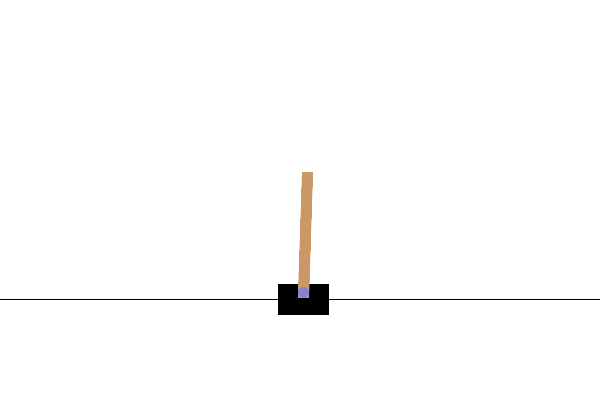

In [ ]:
import tensorflow_docs.vis.embed as embed
embed.embed_file(image_file)

## Next steps

This tutorial demonstrated how to implement the Actor-Critic method using Tensorflow.

As a next step, you could try training a model on a different environment in Gym.

For additional information regarding Actor-Critic methods and the Cartpole-v0 problem, you may refer to the following resources:

- [The Actor-Critic method](https://hal.inria.fr/hal-00840470/document)
- [The Actor-Critic lecture (CAL)](https://www.youtube.com/watch?v=EKqxumCuAAY&list=PLkFD6_40KJIwhWJpGazJ9VSj9CFMkb79A&index=7&t=0s)
- [Cart Pole learning control problem \[Barto, et al. 1983\]](http://www.derongliu.org/adp/adp-cdrom/Barto1983.pdf)

For more reinforcement learning examples in TensorFlow, you can check the following resources:
- [Reinforcement learning code examples (keras.io)](https://keras.io/examples/rl/)
- [TF-Agents reinforcement learning library](https://www.tensorflow.org/agents)
